In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

In [3]:
data_path = '.'

In [4]:
mnist_train = datasets.MNIST(data_path, train=True,
                             download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False,
                            download=True, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [27]:
mnist_train[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [29]:
mnist_train[0][0].shape, mnist_train[0][0].squeeze(0).shape, mnist_train[0][0][0].shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([28, 28]))

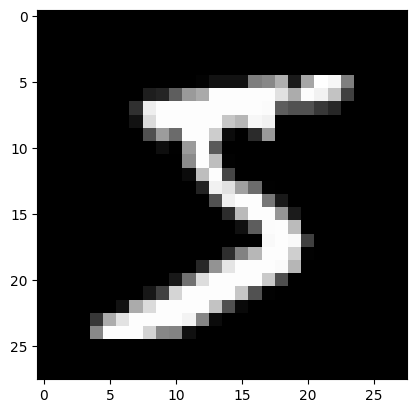

In [31]:
import matplotlib.pyplot as plt 

plt.imshow(mnist_train[0][0].squeeze(), cmap='gray')

In [19]:
batch_size = 64

In [65]:
60000 / 64

937.5

In [20]:
train_loader = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size,
                         shuffle=True, drop_last=True)

In [68]:
len(train_loader)

937

In [77]:
for x,y in train_loader:
    break

In [80]:
x.view(batch_size, -1).shape

torch.Size([64, 784])

tensor(2)


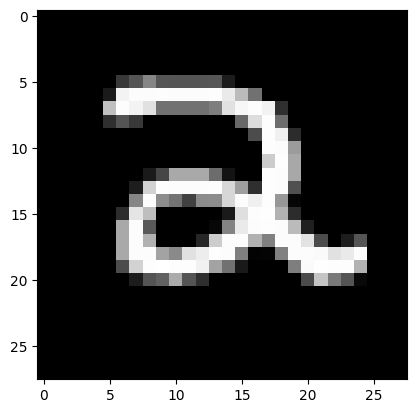

In [45]:
plt.imshow(x[12].squeeze(), cmap='gray')
print(y[12])

In [ ]:
num_inputs = 784 # 28*28 = Dimensione dell'immagine 
num_outputs = 10 # Numero di classi (cifre da 0 a 9)
num_hidden = 1000
beta = 0.99
num_steps = 25

In [21]:
# Definizione della classe Model
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Inizializziamo l'architettura della SNN
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Inizializzazione delle variabili di stato
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Lista per i valori finali
        spk2_rec = []
        mem2_rec = []
        spk1_rec = []
        # Elaborazione dell'input per tutta l'architettura
        # della rete e per tutti i timesteps
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), torch.stack(spk1_rec, dim=0)

# Load the network onto CUDA if available
model = Model()

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [15]:
dtype = torch.float
loss_val = torch.zeros((1), dtype=dtype)
(loss_val.item())

0.0

In [26]:
import numpy as np 
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _, _ = model(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0
dtype = torch.float

# Definizione del traninig loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Training per batch
    for data, targets in train_batch:
        data = data
        targets = targets

        # Forward pass
        model.train()
        spk_rec, mem_rec, spk1_rec = model(data.view(batch_size, -1))

        # Inizializzazione della loss e somma per i timestep
        loss_val = torch.zeros((1), dtype=dtype)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Calcolo del gradiente e aggiornamento dei pesi
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Salvataggio della loss per plot
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            model.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data
            test_targets = test_targets

            # Test set forward pass
            test_spk, test_mem, test_spk1 = model(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 54.26
Test Set Loss: 50.51
Train set accuracy for a single minibatch: 57.81%
Test set accuracy for a single minibatch: 39.06%


Epoch 0, Iteration 50
Train Set Loss: 12.69
Test Set Loss: 18.65
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 79.69%


Epoch 0, Iteration 100
Train Set Loss: 15.58
Test Set Loss: 11.67
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 150
Train Set Loss: 8.46
Test Set Loss: 16.01
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 78.12%


Epoch 0, Iteration 200
Train Set Loss: 7.92
Test Set Loss: 10.73
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 250
Train Set Loss: 6.64
Test Set Loss: 8.26
Train set accuracy for a single minibatch: 98.44%
Test set accuracy for a single minibatch: 89.06%


Epoch

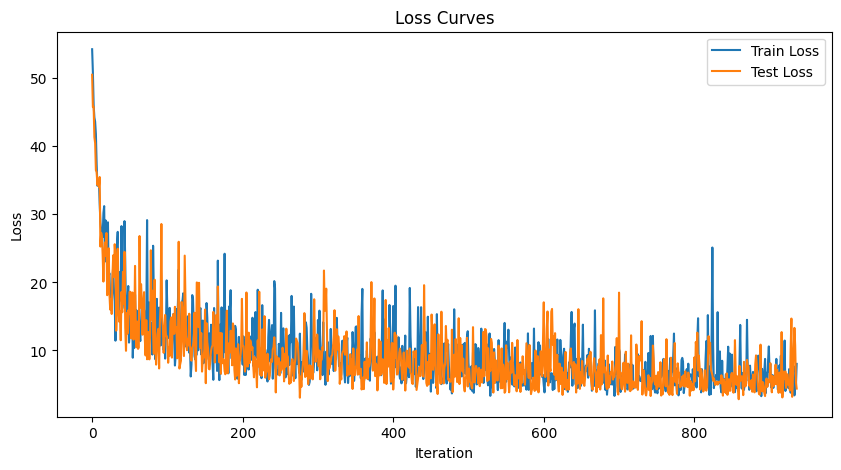

In [29]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [30]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  model.eval()
  for data, targets in test_loader:
    data = data
    targets = targets

    # forward pass
    test_spk, _, _ = model(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [31]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9484/10000
Test Set Accuracy: 94.84%


In [42]:
# imports
from snntorch import spikeplot as splt

#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [ ]:
for data, targets in test_loader:
    data = data
    targets = targets
    break   

tensor(8)


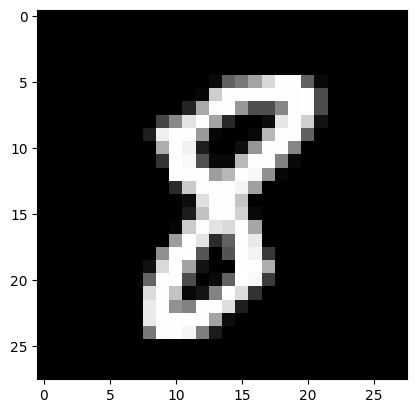

In [53]:
plt.imshow(data[8].squeeze(), cmap='gray')
print(targets[8])

In [54]:
data[8].view(1, -1).shape
spk_in = data[8].view(1,-1)

In [55]:
spk2_rec, mem2_rec, spk1_rec = model(spk_in)

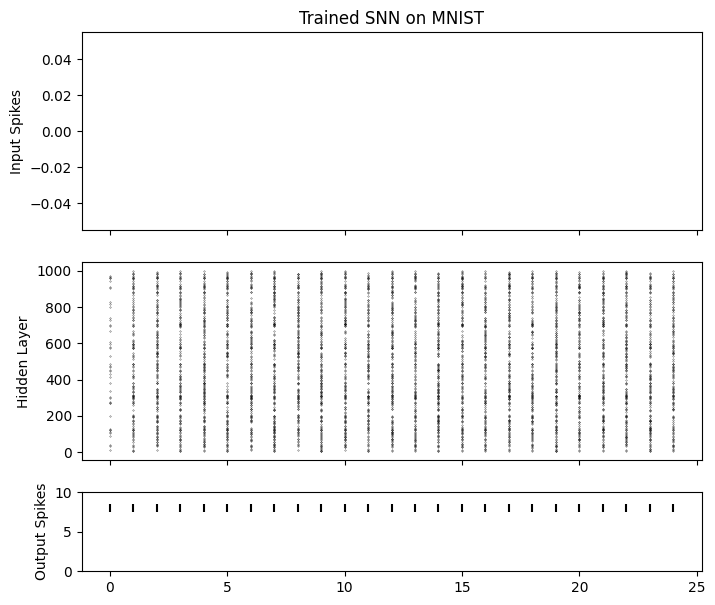

In [56]:
plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Trained SNN on MNIST")